# Seminar Code
In this seminar, I talk about ICA-AROMA and Modular Preprocessing, what they are and how they transform our data in good and/or bad ways.
Many of the figures used in the presentation were generated in here.

In [1]:
# make the images appear inline (in the notebook)
%matplotlib inline

# import many of the basic packages necessary for the demonstrations/visualizations
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.formula.api as smf
from nipype.interfaces.afni.preprocess import TCorr1D

# change settings for graphs so they look better on a dark background
sns.set_palette('bright')
plt.style.use('ggplot')
plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color': "white",
                     'ytick.color': "white"})

## Dummy ICA example
Copied from scikit learn's [website](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html)

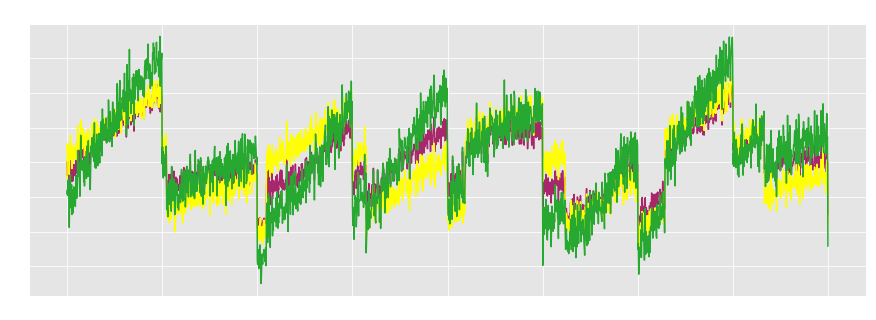

In [2]:
from scipy import signal

from sklearn.decomposition import FastICA, PCA
plt.rcParams["figure.figsize"] = (15,5)
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

plt.title(names[0])
for sig, color in zip(models[0].T, ['#a8276b', '#ffff00', '#27a830']):
    plt.plot(sig, color=color)
plt.savefig('./imgs/observations.png', transparent=True)

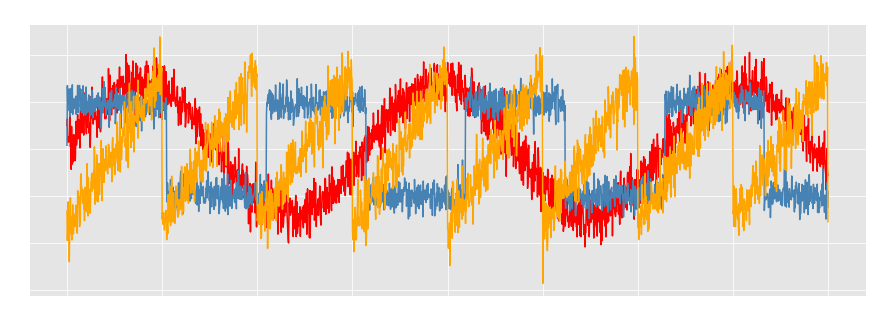

In [3]:
plt.figure()
plt.title(names[1])
for sig, color in zip(models[1].T, colors):
    plt.plot(sig, color=color)
plt.savefig('./imgs/true_sources.png', transparent=True)

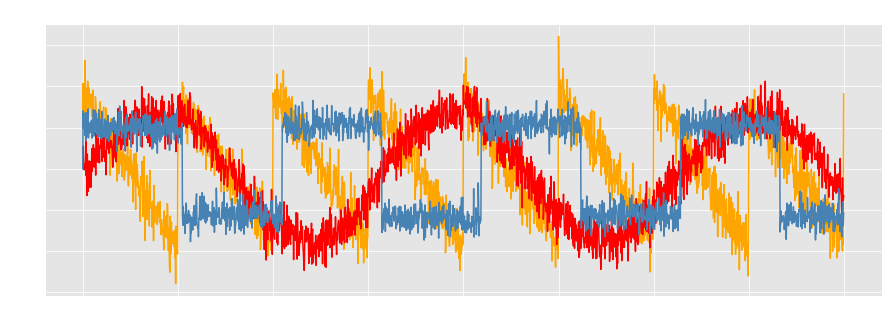

In [4]:
plt.figure()
plt.title(names[2])
for sig, color in zip(models[2].T, [colors[2], colors[0], colors[1]]):
    plt.plot(sig, color=color)
plt.savefig('./imgs/ica_recovered_signals.png', transparent=True)

## Venn Diagram
Visual demonstration of the shared noise between the components

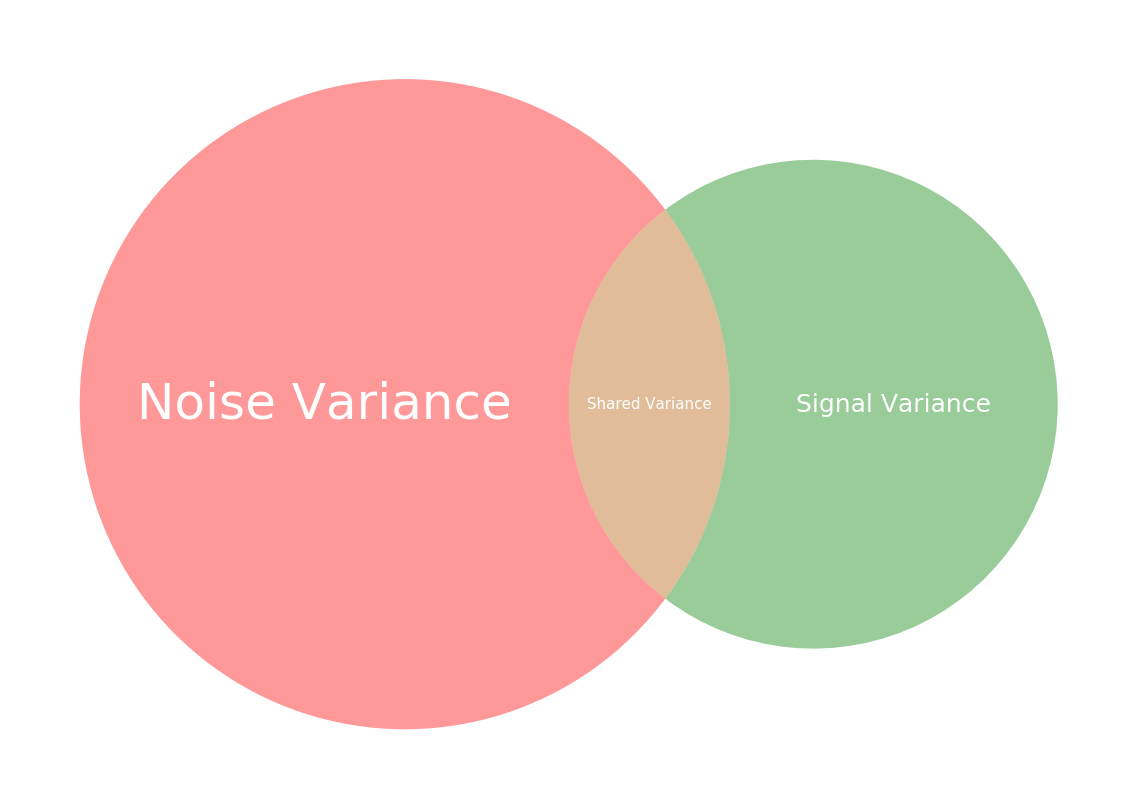

In [5]:
from matplotlib_venn import venn2
plt.rcParams["figure.figsize"] = (20, 20)
venn = venn2(subsets = {'10': 20, '01': 10, '11': 3}, set_labels=None)
venn.get_label_by_id('10').set_text('Noise Variance')
venn.get_label_by_id('10').set_size(50)
venn.get_label_by_id('01').set_text('Signal Variance')
venn.get_label_by_id('01').set_size(25)
venn.get_label_by_id('11').set_text('Shared Variance')
venn.get_label_by_id('11').set_size(15)
plt.savefig('./imgs/venn_diagram.png', transparent=True)
plt.show()

## ICA-AROMA Example
In the following cells I will load in the results of a spatial ICA example on fmri data (data generated via [melodic](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC)). 
- First, I will demonstrate that the timeseries generated by spatial ICA are not independent of each other (as opposed to temporal ICA).
- Second, I will denoise an example voxel (in the left motor cortex) and visualize how denoising the voxel influences whole brain correlations.
    - I will both aggressive and non-aggressive methods to denoise.

In [6]:
# the melodic output giving each ICA timeseries
ica_ts = pd.read_csv('./data/test_bold_MELODICmix.tsv', sep='\t', header=None)
ica_ts.dropna(axis='columns', how='all', inplace=True)
ica_ts = ica_ts.add_prefix('comp_')
ica_ts.head()


,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_63,comp_64,comp_65,comp_66,comp_67,comp_68,comp_69,comp_70,comp_71,comp_72
0,-0.758030,-1.186418,0.790879,-2.197487,1.143364,0.027185,-0.401727,-0.266738,-0.899754,2.957095,...,0.202970,-0.757285,0.580424,-2.170545,1.135138,1.185032,0.161144,-1.449952,-0.340129,3.207329
1,0.855021,1.225001,2.436515,-0.110996,-1.360332,-0.645831,0.705279,-0.529328,-0.961012,3.887399,...,-1.151278,-1.355444,0.157133,-1.456655,-1.614684,-0.420475,2.215335,-0.568601,-1.310884,-0.647429
2,-1.378687,-1.099753,0.282676,-1.600301,-0.390527,-0.477530,-0.573430,-0.526413,-1.896047,2.362592,...,-0.269990,0.657094,0.669171,-0.859728,0.482538,1.614340,-0.225722,-1.383938,1.844453,1.692464
3,3.310646,1.226795,2.549461,0.782276,-0.979568,0.248360,0.926625,-0.615597,-1.456201,3.235565,...,-0.873392,0.517578,0.564591,-1.450724,-1.293111,-1.069044,1.296962,-1.100991,1.450045,-0.018287
4,-1.753966,-1.724009,-0.885913,-2.228024,0.471514,-0.653573,-1.937831,-0.583467,-1.993739,1.610389,...,-0.965310,-0.250692,1.413558,-0.252963,1.918096,1.726810,-0.392606,-1.935342,2.626670,1.386460


In [7]:
# load the noise indices
ica_noise_idx = np.loadtxt('./data/test_bold_AROMAnoiseICs.csv', delimiter=',', dtype='int')
ica_noise_idx -= 1
ica_noise_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 41, 42, 43, 44, 48, 49, 50, 52, 53, 56, 58, 59, 60,
       61, 62, 64, 65, 66, 67, 69, 70, 72])

In [8]:
signal_noise_idx = np.full(len(ica_ts.columns), 'signal')
signal_noise_idx[ica_noise_idx] = 'noise'
signal_noise_idx


array(['noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'signal', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'noise', 'noise', 'signal', 'signal', 'signal', 'noise',
       'noise', 'noise', 'signal', 'noise', 'noise', 'signal', 'signal',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'signal', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'signal', 'noise'], dtype='<U6')

In [9]:
# the noise and signal components aliased to different colors
color_idx = np.array([st.replace('noise', 'red').replace('signal', 'green') for st in signal_noise_idx])
color_idx

array(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'green', 'green', 'green', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'green', 'red', 'green', 'red', 'red', 'red',
       'red', 'red', 'green', 'red', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'red'], dtype='<U5')

In [10]:
# the confounds tsv
confounds = pd.read_csv('./data/test_bold_confounds.tsv', sep='\t')
confounds['FramewiseDisplacement'][0] = confounds['FramewiseDisplacement'][1:].mean()
confounds.head()

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,AROMAAggrComp61,AROMAAggrComp62,AROMAAggrComp63,AROMAAggrComp65,AROMAAggrComp66,AROMAAggrComp67,AROMAAggrComp68,AROMAAggrComp70,AROMAAggrComp71,AROMAAggrComp73
0,4.826616,0.244417,2.084664,NaN,NaN,NaN,0.390440,0.056869,-0.006587,-0.105907,...,1.977688,-0.869653,-1.181006,-0.757285,0.580424,-2.170545,1.135138,0.161144,-1.449952,3.207329
1,-1.675956,0.401133,0.607724,1.245240,10.564131,1.052146,0.619482,-0.001804,0.011459,-0.078431,...,0.173481,-0.326303,-0.542473,-1.355444,0.157133,-1.456655,-1.614684,2.215335,-0.568601,-0.647429
2,1.086976,0.593310,1.711596,1.329685,11.280532,1.202394,0.376306,0.035729,-0.029645,0.066901,...,1.663285,-1.108394,-2.723212,0.657094,0.669171,-0.859728,0.482538,-0.225722,-1.383938,1.692464
3,-0.268196,0.270533,0.871375,1.173665,9.956918,1.019827,0.207354,-0.000183,0.035827,-0.071468,...,-0.443019,1.377220,-0.745638,0.517578,0.564591,-1.450724,-1.293111,1.296962,-1.100991,-0.018287
4,1.103928,0.219790,1.583645,1.300516,11.033072,1.109406,0.497735,0.077244,-0.001720,-0.012880,...,1.480062,-2.249758,-1.405533,-0.250692,1.413558,-0.252963,1.918096,-0.392606,-1.935342,1.386460


In [11]:
# calculate correlations between all the components
correlations = np.corrcoef(ica_ts, rowvar=False)

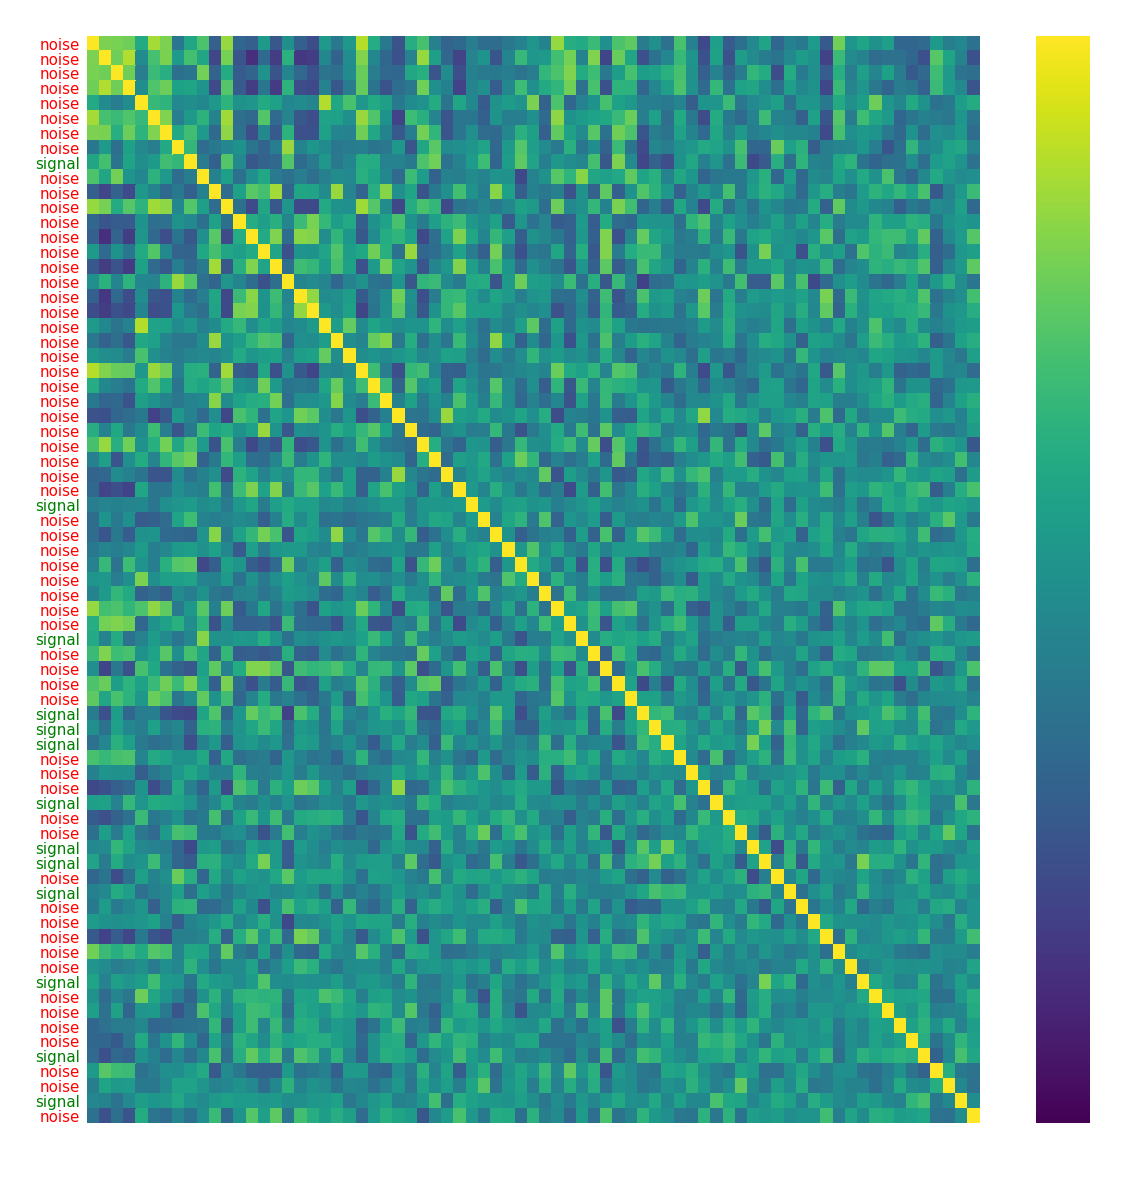

In [12]:
# visualize the components in a heatmap
# make the figure bigger overall
plt.rcParams["figure.figsize"] = (20,20)
fig = sns.heatmap(correlations, 
                  yticklabels=signal_noise_idx, #label the yaxis with individual markers
                  vmin=-1, vmax=1, # set the colorbar to go from -1 to 1
                  cmap='viridis') # have the color gradient go from red to blue
for color,tick in zip(color_idx, fig.yaxis.get_major_ticks()):
    tick.label1.set_color(color) # set the individual colors
    tick.label1.set_fontsize('15') # increase the size
fig.set_ylabel('Classification (Signal or Noise)', fontdict={'fontsize': 25})
fig.set_xlabel('ICA Component Number', fontdict={'fontsize': 25})
fig.set_title('Correlation of ICA Components', fontdict={'fontsize': 30})
plt.savefig('./imgs/correlation_ica_components.png', transparent=True)

In [13]:
# get a voxel in the left motor cortex
# uses millimeter coordinates (not voxel coordinates)
bold_img = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
bold_data = bold_img.get_data()
# voxel coordinates
left_motor = bold_data[14, 39, 29]
left_motor_df = pd.DataFrame.from_dict({'left_motor': left_motor})

/home/james/.conda/envs/seminar/lib/python3.6/site-packages/nibabel/viewers.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vdata = self._data[idx].ravel()


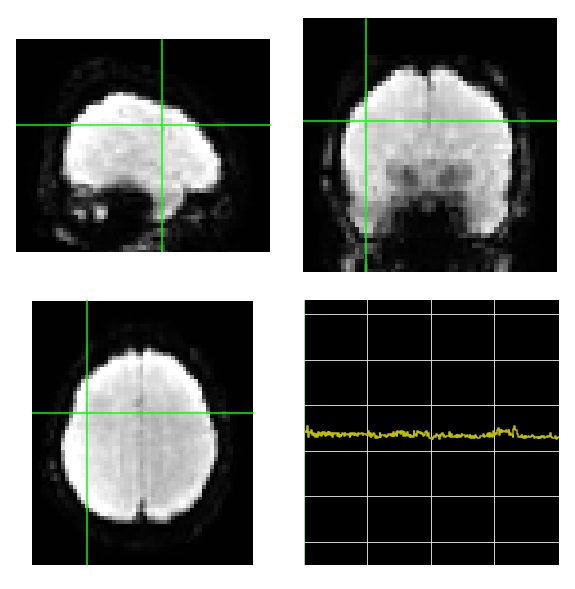

In [14]:
# view the voxel in space
bold_img.orthoview().set_position(x=-48, y=2, z=38)

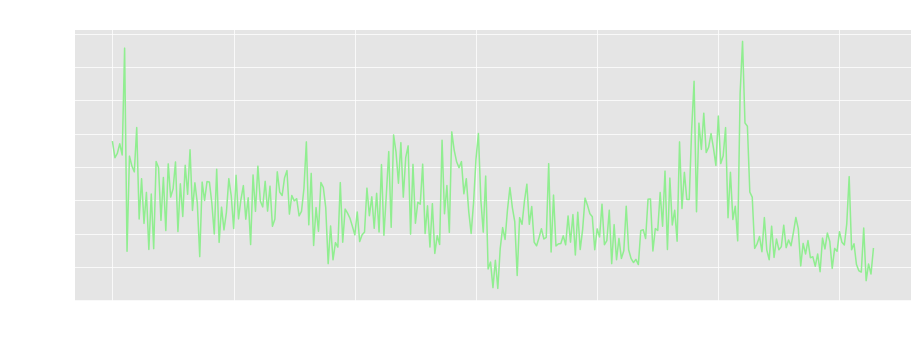

In [15]:
# plot out the left motor voxel
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.figsize"] = (15, 5)
font = {'size': 15}

plt.rc('font', **font)
plt.plot(left_motor_df['left_motor'], color='lightgreen')
plt.title('left motor voxel')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Volumes)')
plt.savefig('./imgs/left_motor_timecourse.png', transparent=True)

In [16]:
# statsmodels (aggressive denoising)
column_names = ica_ts.iloc[:, ica_noise_idx].columns.tolist()
all_columns = "+".join(column_names)

model_agg = smf.ols('left_motor ~ ' + all_columns, 
                    data=pd.concat([ica_ts.iloc[:, ica_noise_idx], left_motor_df], axis='columns'))

In [17]:
fit_agg = model_agg.fit()

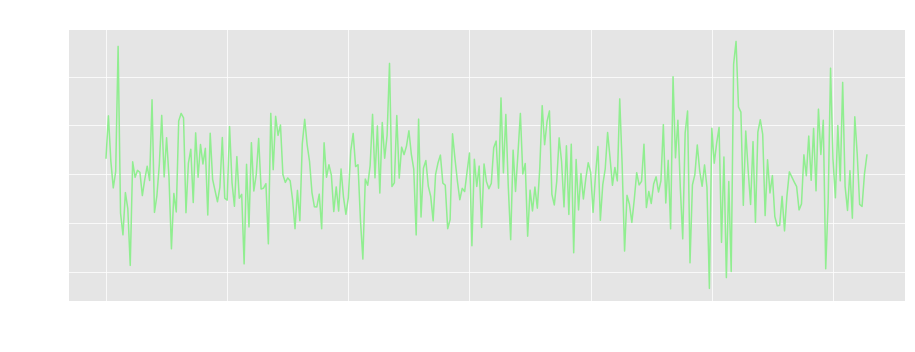

In [18]:
plt.plot(fit_agg.resid, color='lightgreen')
plt.title('left_motor voxel (cleaned)')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Volumes)')
plt.savefig('./imgs/left_motor_timecourse_cleaned.png', transparent=True)

In [19]:
fit_agg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             left_motor   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     33.99
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           4.08e-92
Time:                        13:17:18   Log-Likelihood:                -1107.4
No. Observations:                 315   AIC:                             2337.
Df Residuals:                     254   BIC:                             2566.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1174.4531      0.511   2299.973      0.000    1173.447    1175.459
comp_0         6.7071      1.675      4.005      0.000       3.409      10.005
comp_1         5.3227      2.198      2.421      0.016       0.993       9.652
comp_2         4.0149      1.583      2.536      0.012       0.897       7.133
comp_3        -0.4214      1.673     -0.252      0.801      -3.715       2.873
comp_4         2.3551      1.544      1.525      0.128      -0.685       5.396
comp_5         7.4205      1.412      5.256      0.000       4.640      10.201
comp_6        -2.5117      1.321     -1.901      0.058      -5.113       0.090
comp_7        34.5471      1.240     27.851      0.000      32.104      36.990
comp_9        -1.2716      1.260     -1.009      0.314      -3.753       1.210
comp_10        2.9369      1.364      2.152      0.032       0.250       5.624
comp_11       -1.8999      1.518     -1.252      0.212      -4.889       1.089
comp_12        2.4654      1.167      2.113      0.036       0.168       4.763
comp_13        2.3169      1.351      1.715      0.088      -0.343       4.977
comp_14        2.2171      1.420      1.562      0.120      -0.579       5.013
comp_15        2.3811      1.311      1.816      0.070      -0.200       4.963
comp_16      -14.7712      1.213    -12.175      0.000     -17.160     -12.382
comp_17        2.8897      1.209      2.390      0.018       0.508       5.271
comp_18       -1.8987      1.333     -1.425      0.155      -4.523       0.726
comp_19       -0.6779      1.385     -0.490      0.625      -3.405       2.049
comp_20        2.7658      1.152      2.402      0.017       0.498       5.034
comp_21        1.4767      1.030      1.433      0.153      -0.552       3.506
comp_22       -3.4944      1.275     -2.741      0.007      -6.005      -0.984
comp_23        2.3042      1.266      1.820      0.070      -0.189       4.797
comp_24        1.2069      1.015      1.190      0.235      -0.791       3.205
comp_25        1.7200      1.199      1.434      0.153      -0.642       4.082
comp_26        6.0190      1.175      5.124      0.000       3.706       8.332
comp_27        1.5146      1.104      1.372      0.171      -0.660       3.689
comp_28       -2.2526      1.239     -1.818      0.070      -4.692       0.187
comp_29        0.1706      1.136      0.150      0.881      -2.066       2.407
comp_30        1.0616      1.006      1.056      0.292      -0.919       3.042
comp_32        6.8705      1.206      5.695      0.000       4.495       9.246
comp_33        2.9261      1.144      2.558      0.011       0.673       5.179
comp_34       -0.3612      1.023     -0.353      0.724      -2.375       1.653
comp_35       -2.7372      1.155     -2.369      0.019      -5.013      -0.462
comp_36       -0.1333      1.162     -0.115      0.909      -2.421       2.154
co

In [20]:
# non-aggressive (you generate the betas for the noise components...
# while condsidering the variance that is explained by the signal components...
# then you subtract that "fitted" model from the original data
all_comps = '+'.join([str(x) for x in ica_ts.columns.tolist()])
model_noise = smf.ols('left_motor ~ ' + all_comps, data=pd.concat([ica_ts, left_motor_df], axis='columns'))
fit_noise = model_noise.fit()
noise_series = np.dot(ica_ts.iloc[:,ica_noise_idx], fit_noise.params[ica_noise_idx])
left_motor_nonaggr = left_motor_df['left_motor'] - noise_series

In [21]:
# write three text files for analysis
fit_agg.resid.to_csv('./data/left_motor-aggr.txt', index=False)
left_motor_df.to_csv('./data/left_motor-orig.txt', index=False, header=False)
left_motor_nonaggr.to_csv('./data/left_motor-nonaggr.txt', index=False)

In [22]:

afni_corr_objs = {}
for signal in ['orig', 'aggr', 'nonaggr']:
    # check to see if the file already exists (don't want people to have to install AFNI)
    if not os.path.isfile('./data/motor-{sig}_corr.nii.gz'.format(sig=signal)):
        afni_corr = TCorr1D(xset='./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                            y_1d='./data/left_motor-{sig}.txt'.format(sig=signal),
                            args='-mask ./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
                            out_file='./data/motor-{sig}_corr.nii.gz'.format(sig=signal))
        res = afni_corr.run()
        afni_corr_objs[signal] = res.outputs.out_file
    else:
        afni_corr_objs[signal] = './data/motor-{sig}_corr.nii.gz'.format(sig=signal)


orig
aggr
nonaggr


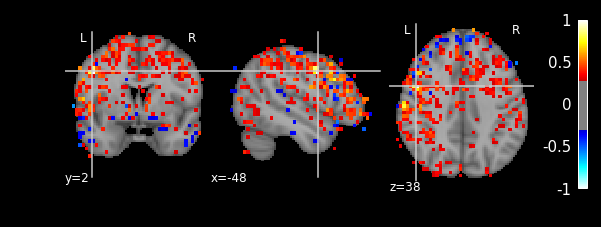

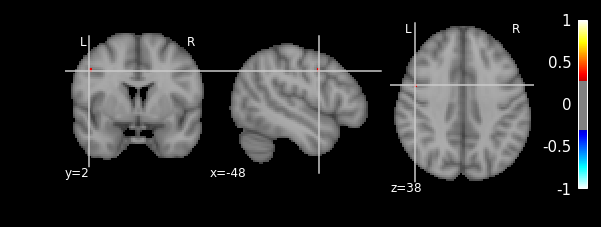

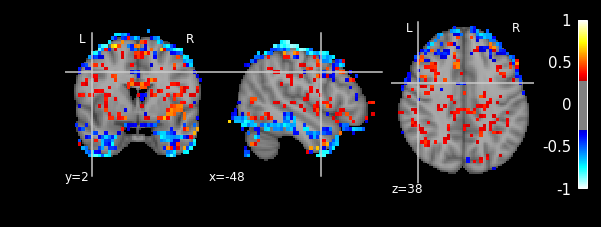

In [23]:
# plot the original correlation, the aggressive correlation...
# and the non-aggressive correlation
from nilearn.plotting import plot_stat_map
for signal, stat in afni_corr_objs.items():
    print(signal)
    plot_stat_map(stat, threshold=0.3, cut_coords=[-48, 2, 38], vmax=1.0, black_bg=True)
    plt.savefig('./imgs/{sig}_brain.png'.format(sig=signal), transparent=True)


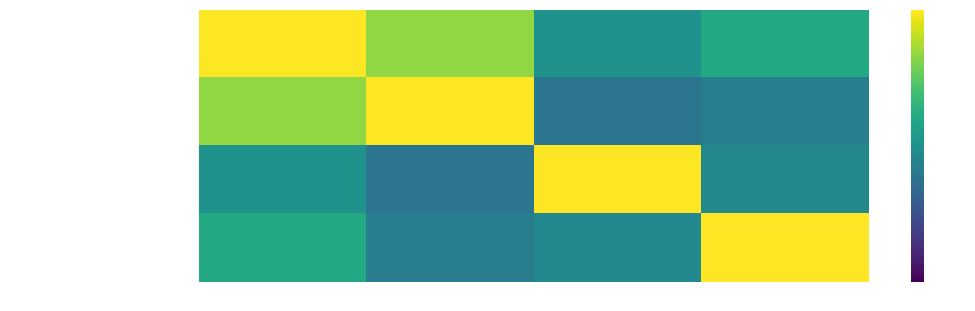

In [24]:
# see which denoising strategy still correlates with a measure of motion.
names = ['aggressive', 'original', 'nonaggressive']

sns.heatmap(np.corrcoef(np.array([fit_agg.resid, left_motor_df['left_motor'], left_motor_nonaggr]), confounds['FramewiseDisplacement'].T), 
            yticklabels=names + ['FramewiseDisplacement'], # label the yaxis with individual markers
            xticklabels=names + ['FramewiseDisplacement'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap='viridis')

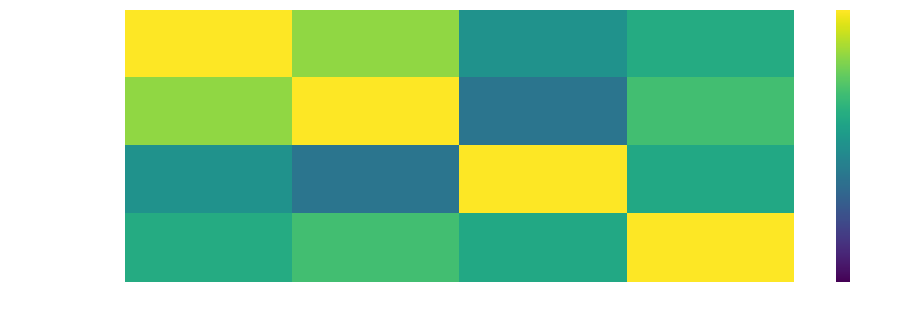

In [25]:
# see which measures correlate with the global signal
sns.heatmap(np.corrcoef(np.array([fit_agg.resid, left_motor_df['left_motor'], left_motor_nonaggr]), confounds['GlobalSignal'].T), 
            yticklabels=names + ['GlobalSignal'], # label the yaxis with individual markers
            xticklabels=names + ['GlobalSignal'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap="viridis")

## Modular Preprocessing
Demonstrating that if confounds are not orthagonal and if you do a step by step regression, then you re-introduce correlations with your confounds.

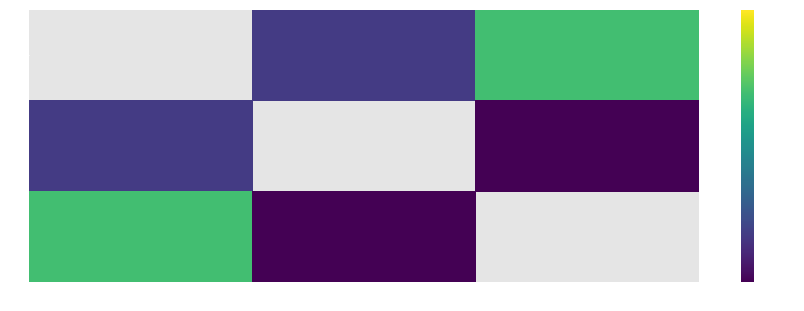

In [26]:
# left motor, motion (framewise displacement), and global signal
confound1 = confounds.aCompCor00
confound2 = confounds.GlobalSignal
modular_df = pd.concat([confound1, confound2, left_motor_df['left_motor']], axis='columns')
modular_df.columns = ['confound1', 'confound2', 'left_motor']
orig_corr = np.corrcoef([left_motor, confound1, confound2])
np.fill_diagonal(orig_corr, np.NaN)
sns.heatmap(orig_corr, vmin=-0.5, vmax=0.5, cmap='viridis')

In [27]:
# model confound1 then confound2
model_conf1 = smf.ols('left_motor ~ confound1', data=modular_df)
fit_conf1 = model_conf1.fit()
modular_df['left_motor_conf1'] = fit_conf1.resid
model_conf1_conf2 = smf.ols('left_motor_conf1 ~ confound2', data=modular_df)
fit_conf1_conf2 = model_conf1_conf2.fit()
modular_df['left_motor_conf1_conf2'] = fit_conf1_conf2.resid

# model confound2 then confound1
model_conf2 = smf.ols('left_motor ~ confound2', data=modular_df)
fit_conf2 = model_conf2.fit()
modular_df['left_motor_conf2'] = fit_conf2.resid
model_conf2_conf1 = smf.ols('left_motor_conf2 ~ confound1', data=modular_df)
fit_conf2_conf1 = model_conf2_conf1.fit()
modular_df['left_motor_conf2_conf1'] = fit_conf2_conf1.resid

# simultaneous
model_simult = smf.ols('left_motor ~ confound1 + confound2', data=modular_df)
fit_simult = model_simult.fit()
modular_df['left_motor_simult'] = fit_simult.resid

In [28]:
# original correlation
orig_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'left_motor']], rowvar=False)
# reintroduce correlations with confound1
conf1_conf2_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'left_motor_conf1_conf2']], rowvar=False)
# reintroduce correlations with confound2
conf2_conf1_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'left_motor_conf2_conf1']], rowvar=False)
# no correlations with confounds
simult_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'left_motor_simult']], rowvar=False)
corrs = [orig_corr, conf1_conf2_corr, conf2_conf1_corr, simult_corr]

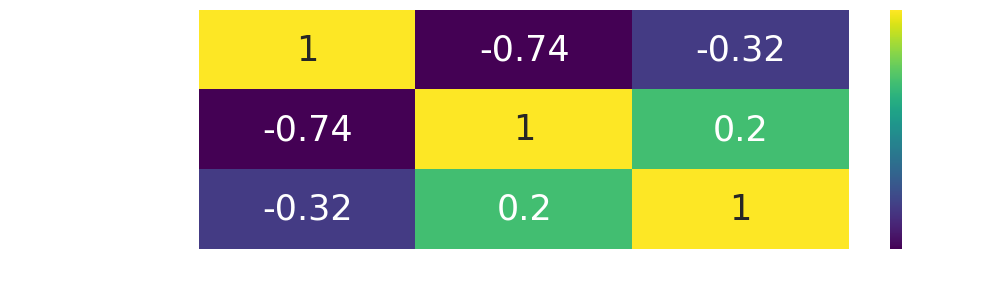

In [29]:
font = {'size': 35}

plt.rc('font', **font)

orig_corr_hm = sns.heatmap(corrs[0], vmin=-0.5, vmax=0.5, cmap='viridis', 
                           xticklabels=['confound1', 'confound2', 'left_motor'],
                           yticklabels=['confound1', 'confound2', 'left_motor'],
                           annot=True,
                           )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_orig.png', transparent='True')

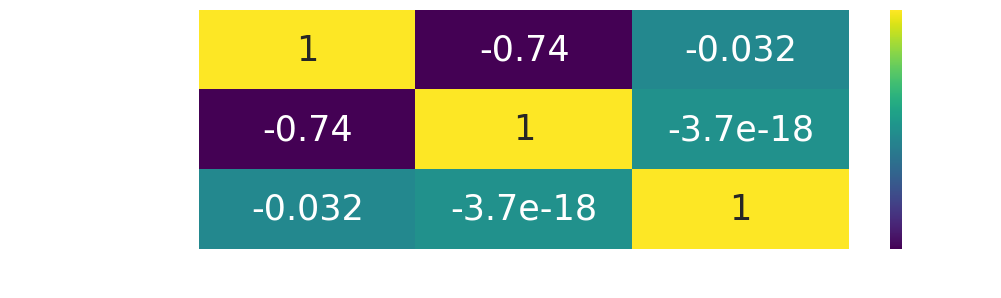

In [30]:
conf1_conf2_corr_hm = sns.heatmap(corrs[1], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'left_motor'],
                                  yticklabels=['confound1', 'confound2', 'left_motor'],
                                  annot=True,
                                  )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_conf1-conf2.png', transparent='True')

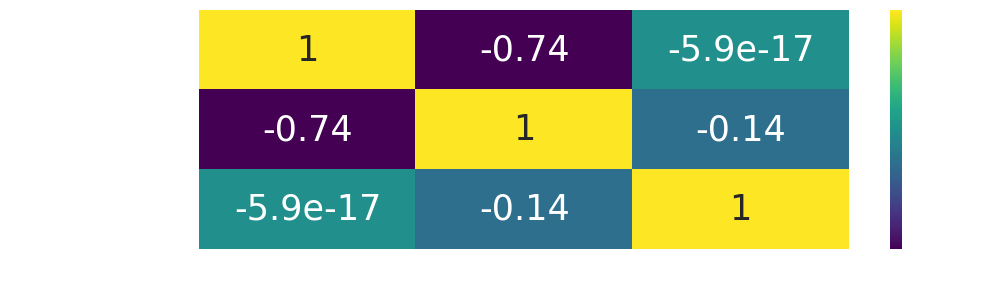

In [31]:
conf2_conf1_corr_hm = sns.heatmap(corrs[2], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'left_motor'],
                                  yticklabels=['confound1', 'confound2', 'left_motor'],
                                  annot=True,
                                  )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_conf2-conf1.png', transparent='True')

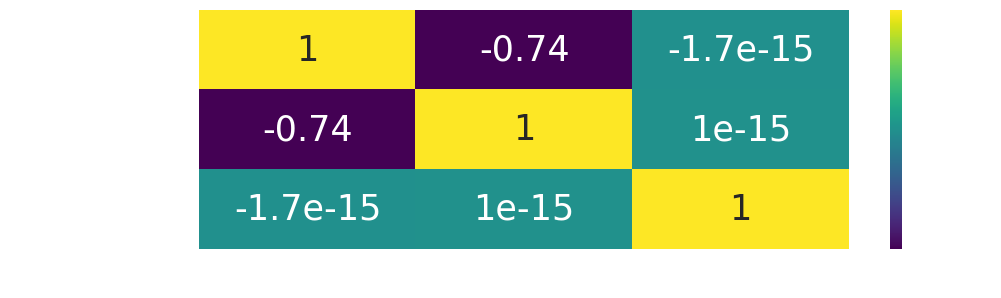

In [32]:
simult_corr_hm = sns.heatmap(corrs[3], vmin=-0.5, vmax=0.5, cmap='viridis', 
                             xticklabels=['confound1', 'confound2', 'left_motor'],
                             yticklabels=['confound1', 'confound2', 'left_motor'],
                             annot=True,
                             )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_simult.png', transparent='True')